# Zadání I. seminární práce z předmětu Počítačové zpracování signálu (KI/PZS)

## 1. Výpočet tepové frekvence z EKG signálu 

Channels: ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'RESP']
Sampling frequeny: 15.5


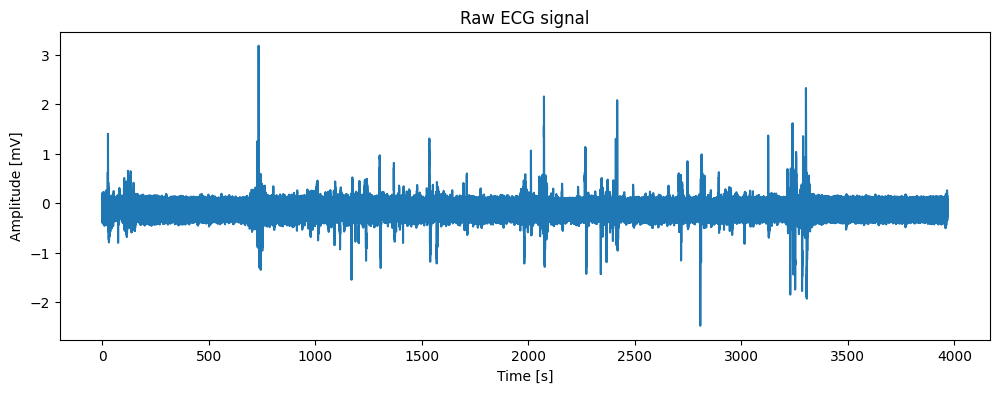

Sampling frequency: 15.5 Hz
Signal length: 3967.68 seconds


In [ ]:
#Importy
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal

#Nacteni dat
file_path = "C:\\Users\\Meter\\Desktop\\KI_PZS_Seminarky\\stress-recognition-in-automobile-drivers-1.0.0\\stress-recognition-in-automobile-drivers-1.0.0"
data = wfdb.rdrecord(file_path + "\\drive01")
ecg_signal = data.p_signal[:, 0]
sampling_rate = data.fs
print("Channels:", getattr(data, "sig_name", None))
print("Sampling frequeny:", data.fs)


plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(ecg_signal))/sampling_rate, ecg_signal)
plt.title("Raw ECG signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.show()


print(f"Sampling frequency: {sampling_rate} Hz")
print(f"Signal length: {len(ecg_signal)/sampling_rate:.2f} seconds")

Detected 5047 R-peaks, Mean HR: 87.26 bpm


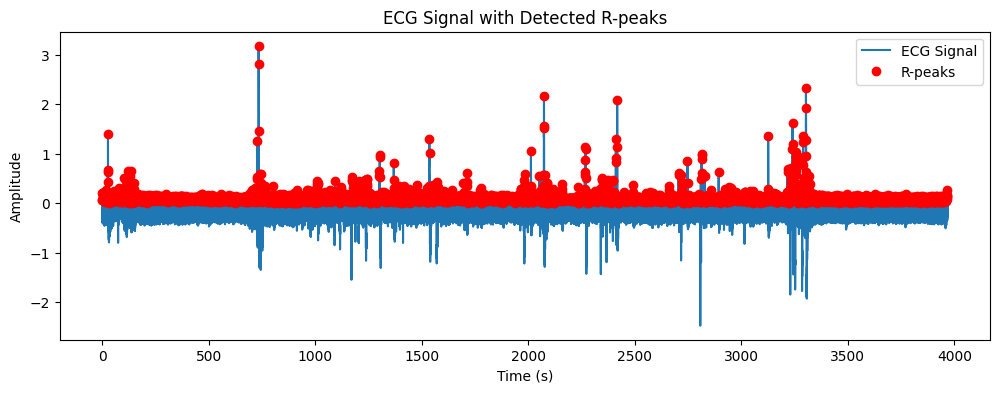

Detected 5047 R-peaks, Mean HR: 87.26 bpm


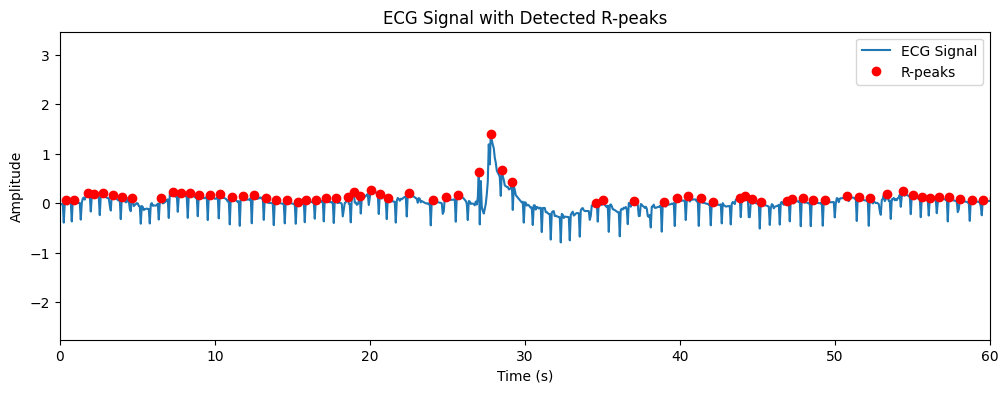

In [ ]:
#Vyhledani r-peaku
def find_r_peaks(ecg_signal, sampling_rate, min_rr_sec=0.30, r_peak_height=0.0, prominence=0.5):
    
    x = np.asarray(ecg_signal, float)
    fs = float(sampling_rate)
    if x.size == 0 or fs <= 0:
        return np.array([], dtype=int), {"error": "empty signal or invalid sampling_rate"}
    
    
    xz= (x - np.mean(x)) / (np.std(x) + 1e-12)

    
    distance = max(1, int(min_rr_sec * fs))
    height = np.mean(xz) + r_peak_height * np.std(xz)

    peaks, props = signal.find_peaks(xz, height=height, distance=distance, prominence=prominence)

    return peaks.astype(int)


#vypocet pro tepovou frekvenci 
def compute_heart_rate(r_peaks_idx, sampling_rate):

    r_peaks_idx = np.asarray(r_peaks_idx, dtype=int)
    fs = float(sampling_rate)


    r_times = r_peaks_idx / fs
    rr = np.diff(r_times)
    valid = (rr > 0.3) & (rr < 2.1)
    rr_valid = rr[valid]
    times_valid = (r_times[1:] + r_times[:-1]) / 2.0
    times_valid = times_valid[valid]



    hr_bpm = 60.0 / rr_valid
    mean_bpm = float(np.mean(hr_bpm)) if hr_bpm.size else np.nan
    return hr_bpm, times_valid, mean_bpm



#wrapper pro find_r_peaks a compute_heart_rate
def process_ecg(ecg_signal, sampling_rate):

    r_peaks = find_r_peaks(ecg_signal, sampling_rate)
    hr_bpm, hr_times_s, mean_bpm = compute_heart_rate(r_peaks, sampling_rate)
    return r_peaks, hr_times_s, hr_bpm, mean_bpm



# VYSLEDEK
r_peaks, hr_times_s, hr_bpm, mean_bpm = process_ecg(ecg_signal, sampling_rate)
print(f"Detected {len(r_peaks)} R-peaks, Mean HR: {mean_bpm:.2f} bpm")
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(ecg_signal))/sampling_rate, ecg_signal, label="ECG Signal")
plt.plot(r_peaks/sampling_rate, ecg_signal[r_peaks], 'ro', label="R-peaks")
plt.title("ECG Signal with Detected R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


# priblizeni poctu tepu za minutu
print(f"Detected {len(r_peaks)} R-peaks, Mean HR: {mean_bpm:.2f} bpm")
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(ecg_signal))/sampling_rate, ecg_signal, label="ECG Signal")
plt.plot(r_peaks/sampling_rate, ecg_signal[r_peaks], 'ro', label="R-peaks")
plt.xlim(0, 60)  # za minutu
plt.title("ECG Signal with Detected R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [ ]:
# vyhodnoceni algoritmu na testovacich dat
file_path = "C:\\Users\\Meter\\Desktop\\KI_PZS_Seminarky\\mit-bih-normal-sinus-rhythm-database-1.0.0\\mit-bih-normal-sinus-rhythm-database-1.0.0"

record = wfdb.rdrecord(file_path + '\\16265')
ann = wfdb.rdann(file_path + '\\16265', 'atr')

ecg = record.p_signal[:, 0]
fs = record.fs

reference = ann.sample # R-peak annotations

r_peaks, hr_times_s, hr_bpm, mean_bpm = process_ecg(ecg, fs)

hr_actual = len(reference) / (len(ecg)/fs / 60)
hr_detected = len(r_peaks) / (len(ecg)/fs / 60)
accuracy = 100 - (abs(hr_actual - hr_detected) / hr_actual * 100)

print(f"Actual heart rate: {hr_actual:.1f} bpm")
print(f"Detected heart rate: {hr_detected:.1f} bpm")
print(f"Detection accuracy: {accuracy:.2f}%")



patient_list = ['16265', '16272', '16273', '16420', '16483', '16539', '16773', '16786', '16795', '17052', '17453', '18177', '18184', '19088', '19090', '19093', '19140', '19830']
results = []

for patient_id in patient_list:
    record = wfdb.rdrecord(file_path + f'\\{patient_id}')
    ann = wfdb.rdann(file_path + f'\\{patient_id}', 'atr')

    ecg = record.p_signal[:, 0]
    fs = record.fs
    reference = ann.sample

    r_peaks, hr_times_s, hr_bpm, mean_bpm = process_ecg(ecg, fs)

    hr_actual = len(reference) / (len(ecg)/fs / 60)
    hr_detected = len(r_peaks) / (len(ecg)/fs / 60)
    accuracy = 100 - (abs(hr_actual - hr_detected) / hr_actual * 100)

    results.append({
        'patient_id': patient_id,
        'actual_hr_bpm': hr_actual,
        'detected_hr_bpm': hr_detected,
        'accuracy (%)': accuracy
    })

overall_accuracy = (lambda r: (sum(x.get('accuracy (%)', 0) for x in r) / len(r)) if len(r) else float('nan'))(results)

results_df = pd.DataFrame(results)

print(results_df, "\n")
print(f"Overall accuracy: ", round(overall_accuracy), "%")

Actual heart rate: 66.1 bpm
Detected heart rate: 77.0 bpm
Detection accuracy: 83.55%
   patient_id  actual_hr_bpm  detected_hr_bpm  accuracy (%)
0       16265      66.093095        76.964036     83.552078
1       16272      64.764000        78.551333     78.711424
2       16273      60.942235        76.003788     75.285526
3       16420      71.188844        73.652474     96.539303
4       16483      67.141053        67.655394     99.233940
5       16539      73.680618        90.864446     76.677954
6       16773      78.487903        60.984427     77.699142
7       16786      69.241606        77.699864     87.784429
8       16795      61.966170        76.180974     77.060380
9       17052      63.402017        68.535303     91.903593
10      17453      69.157629        74.198186     92.711494
11      18177      75.130993        94.593108     74.095757
12      18184      72.060640        75.567799     95.133045
13      19088      82.549020        70.486695     85.387682
14      19090  

Jak jsem zjistil, algoritmus dosahuje průměrné přesnosti 86 %, což nemusí být zcela dostačující. Při detailnějším pohledu na jednotlivé výsledky však vidím, že přesnost se pohybuje v rozmezí 72 % až 99 % v závislosti na konkrétních vstupních datech. Z toho vyplývá, že kvalita a charakter vstupních dat mají zásadní vliv na výslednou úspěšnost modelu.

Tento algoritmus bych však nepovažoval za dostatečně stabilní pro přesné určování tepové frekvence, protože jeho výstupy vykazují určitou míru nestability.